In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

from IPython.display import Video

1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

design_region_length = 7 # (μm)
design_region_width = 4 # (μm)
design_region_thickness= 0.22


arm_separation = design_region_width - 0.5 # (μm) distance between arms center to center
waveguide_width = 0.5 # (μm)
waveguide_length = 0.5 # (μm)
waveguide_thickness = design_region_thickness
pml_size = 1.0 # (μm)
resolution = 50 # (pixels/μm)

In [3]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_length)
Ny = int(design_region_resolution*design_region_width)
Nz = int(design_region_resolution*design_region_thickness)###

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)### not giving a Nz because we want it to extent in the z axis so you give the z direction width in the volumn
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_length, design_region_width, design_region_thickness)))###

In [4]:
Sx = 2*pml_size + 2*waveguide_length + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 3 # cell size in Y
Sz = 2*pml_size + design_region_thickness + 1 # cell size in Z ###

cell_size = mp.Vector3(Sx,Sy,Sz)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,1,0.5)###
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size + waveguide_length/3,-arm_separation/2,0]

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]



# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]





geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, waveguide_thickness)), # top left waveguide
    mp.Block(center=mp.Vector3(x=-Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, waveguide_thickness)), # bottom left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, waveguide_thickness)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, waveguide_thickness)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables) ## the size here extends the design region in z direction
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

  

<Axes: xlabel='X', ylabel='Y'>

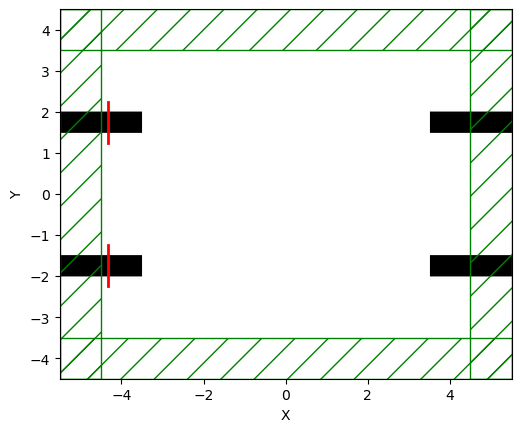

In [5]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

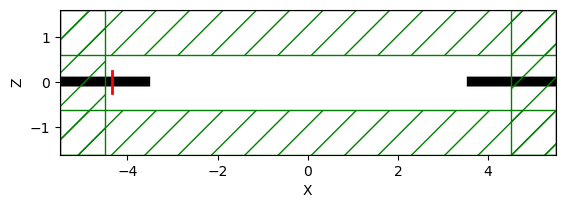

In [6]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=arm_separation/2),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

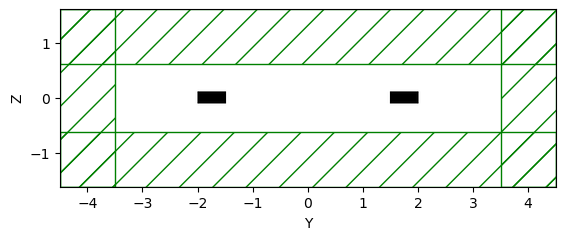

In [7]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-design_region_length/2-0.1), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [8]:
def mapping(x,eta,beta):
    
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry
    
    # filter
    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    
    #filtered_field = mpa.cylindrical_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

<Axes: xlabel='X', ylabel='Y'>

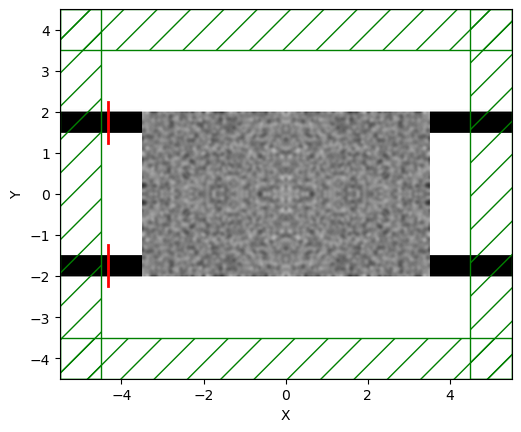

In [9]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,5))
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

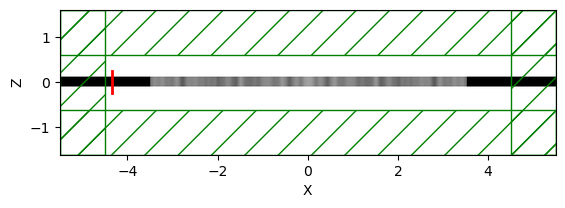

In [10]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=arm_separation/2),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

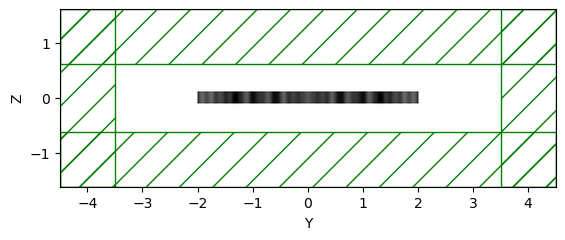

In [11]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.01), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [12]:
mode = 1

monitor_z=0.5

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 2*waveguide_length/3, y=arm_separation/2),
            size=mp.Vector3(y=2, z=monitor_z)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 2*waveguide_length/3,arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2, z=monitor_z)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 2*waveguide_length/3,-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2, z=monitor_z)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(output,top_source,bottom_source):
    power = npa.abs(output/top_source) ** 2 + npa.abs(output/bottom_source) ** 2 
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)


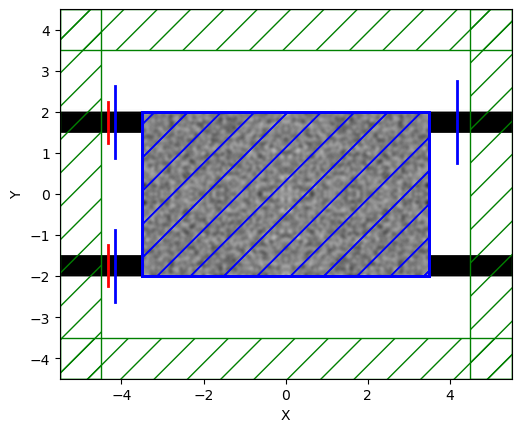

In [13]:
opt.plot2D(True, output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

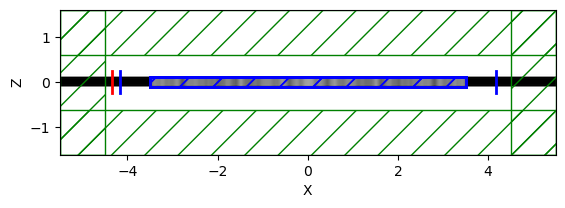

In [14]:
opt.plot2D(True,
    output_plane = mp.Volume(
        center = mp.Vector3(y=arm_separation/2),
        size = mp.Vector3(x=Sx,z=Sz)))

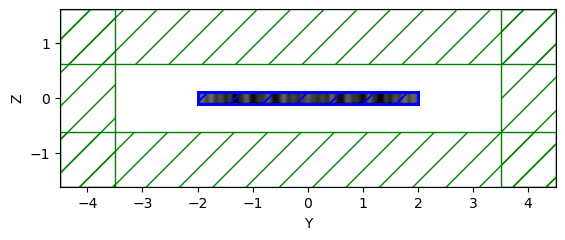

In [15]:
opt.plot2D(True,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.01), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

For now, just proceed without much consideration, just assume the monitor positions as the endpoints of the device

In [16]:
x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

#just for the same of a boundary value
x0=np.where(x0>1,1,x0)
x0=np.where(x0<0,0,x0)

#x0 = np.random.rand(Nx,Ny)
f0, g0 = opt([mapping(x0,0.5,2)])

In [ ]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
from autograd import tensor_jacobian_product
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
import nlopt
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)])
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False, output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))
    ax.axis('off')
    plt.show()
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,np.sum(dJ_du,axis=1))
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

In [ ]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5 # + np.random.normal(loc=mean, scale=std, size=(n,))
#x = np.random.rand(n,) 

#just for the same of boundary value
x=np.where(x>1,1,x)
x=np.where(x<0,0,x)

# lower and upper bounds
lb = 0
ub = 1

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 30
for iters in range(num_betas):
    print("current beta: ",cur_beta)
    
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale



final_beta = 10000
update_factor = 1
print("----------------------------------------------------------------")
print('final binarization')
    
solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(lb)
solver.set_upper_bounds(ub)
solver.set_max_objective(lambda a,g: f(a,g,final_beta))
solver.set_maxeval(update_factor)
x[:] = solver.optimize(x)

In [ ]:
plt.figure()
plt.plot(10*np.log10(0.5*np.array(evaluation_history)),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Mean Splitting Ratio (dB)')
plt.show()

In [ ]:

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1)]



sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)


mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3, y=arm_separation/2),
            size=mp.Vector3(y=2)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J2(input,top_output,bottom_output):
    power = npa.abs(top_output/input) ** 2 + npa.abs(bottom_output/input) ** 2 
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)

opt.plot2D(True, output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

In [ ]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2


In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,1-(np.abs(top_coef) ** 2 + np.abs(bottom_ceof) ** 2)/np.abs(source_coef) ** 2,'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_ceof) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=200)


In [ ]:
plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=100)
plt.close()

In [ ]:
filename = "dc_trial_cw.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=200)


In [ ]:
plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=100)
plt.close()

In [ ]:
filename = "dc_7x4_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
